In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
import time
import pysuperansac
import sys
import cv2
import io
import requests
from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image, rbd

In [3]:
def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename

#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(img1,kps1,img2,kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [4]:
# Parameters
device = torch.device('cuda')

# Initialize the detector and matcher
detector = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features='superpoint').eval().to(device)  # load the matcher

In [5]:
# Download the images
url_a = "https://github.com/kornia/data/raw/main/homography/img1.ppm"
url_b = "https://github.com/kornia/data/raw/main/homography/img2.ppm"

download_image(url_a)
download_image(url_b)

img1 = cv2.cvtColor(cv2.imread("img1.ppm", cv2.IMREAD_ANYCOLOR), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("img2.ppm", cv2.IMREAD_ANYCOLOR), cv2.COLOR_BGR2RGB)

torch_img1 = torch.from_numpy(img1).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255.
torch_img2 = torch.from_numpy(img2).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255.

1159 SP+LG matches are found in 0.54 seconds


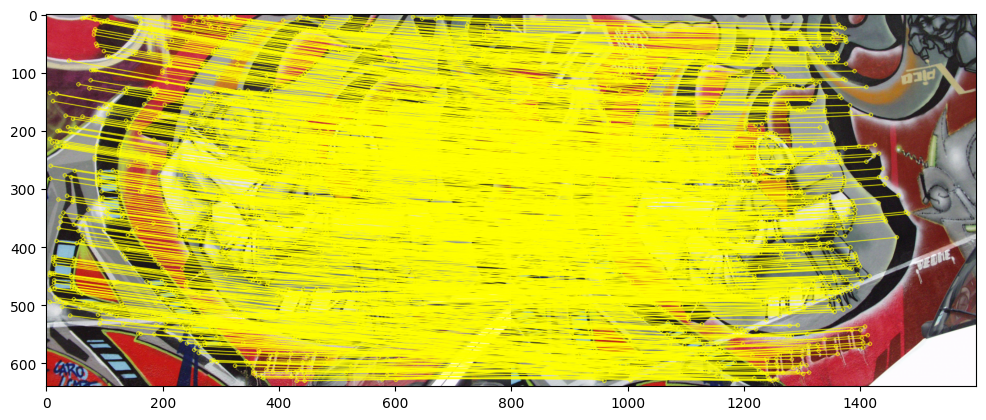

In [6]:
start_time = time.time()
with torch.inference_mode():
    # extract local features
    feats0 = detector.extract(torch_img1.to(device))  # auto-resize the image, disable with resize=None
    feats1 = detector.extract(torch_img2.to(device))
    
    # match the features
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
    matches = matches01['matches']  # indices with shape (K,2)
    points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
    points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)
end_time = time.time()

splg_matches = np.concatenate([points0.cpu().numpy(), points1.cpu().numpy()], axis=1), matches01["scores"].cpu().numpy()
print(f"{splg_matches[0].shape[0]} SP+LG matches are found in {end_time - start_time:.2f} seconds")

# Order by the score
splg_matches = splg_matches[0][np.argsort(splg_matches[1])[::-1]], np.sort(splg_matches[1])[::-1]

draw_matches([cv2.KeyPoint(splg_matches[0][i][0], splg_matches[0][i][1], 1) for i in range(splg_matches[0].shape[0])], 
             [cv2.KeyPoint(splg_matches[0][i][2], splg_matches[0][i][3], 1) for i in range(splg_matches[0].shape[0])], 
             [cv2.DMatch(i, i, 1) for i in range(splg_matches[0].shape[0])], 
             img1, img2, 
             np.array(splg_matches[0].shape[0] * [1]))

In [7]:
def run_cv2(matches):
    # Run the fundamental matrix estimation implemented in OpenCV
    tic = time.perf_counter()
    src_pts = matches[:,0:2]
    dst_pts = matches[:,2:4]
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.USAC_MAGSAC, 1.5)
    toc = time.perf_counter()
    elapsed_time = toc - tic
    print (f'{int(deepcopy(mask).astype(np.float32).sum())} inliers found by OpenCV (USAC_MAGSAC) in {elapsed_time:0.3f} seconds')
    return H, mask

def run_superansac(matches, config, image_size1, image_size2):
    # Run the fundamental matrix estimation implemented in SupeRANSAC
    tic = time.perf_counter()
    H, inliers, score, iterations = pysuperansac.estimateHomography(
        np.ascontiguousarray(matches), 
        [image_size1[1], image_size1[0], image_size2[1], image_size2[0]],
        [],
        config = config)
    toc = time.perf_counter()
    elapsed_time = toc - tic
    print (f'{len(inliers)} inliers found by SupeRANSAC in {elapsed_time:0.3f} seconds')

    mask = np.zeros((matches.shape[0], 1), dtype=np.uint8)
    mask[inliers] = 1

    return H, mask


825 inliers found by OpenCV (USAC_MAGSAC) in 0.001 seconds
1152 inliers found by SupeRANSAC in 0.047 seconds


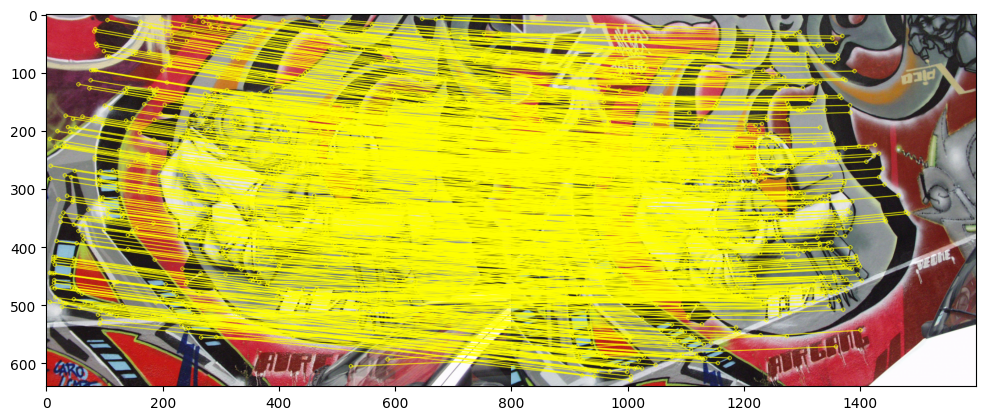

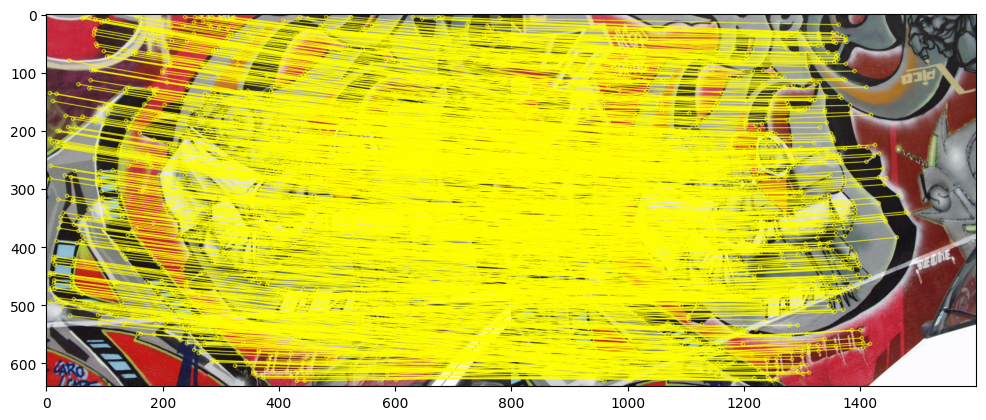

In [8]:
# Set up the configuration
config = pysuperansac.RANSACSettings()
config.inlier_threshold = 5.0
config.min_iterations = 1000
config.max_iterations = 50
config.confidence = 0.999
config.sampler = pysuperansac.SamplerType.PROSAC
config.scoring = pysuperansac.ScoringType.MAGSAC
config.local_optimization = pysuperansac.LocalOptimizationType.GCRANSAC
config.final_optimization = pysuperansac.LocalOptimizationType.IteratedLSQ
config.neighborhood_settings.neighborhood_grid_density = 6
config.neighborhood_settings.neighborhood_size = 6

# Run OpenCV RANSAC 
H_cv2, mask_cv2 = run_cv2(splg_matches[0])

# Run OpenCV RANSAC 
H_sr, mask_sr = run_superansac(splg_matches[0], config, img1.shape, img2.shape)

draw_matches([cv2.KeyPoint(splg_matches[0][i][0], splg_matches[0][i][1], 1) for i in range(splg_matches[0].shape[0])], 
             [cv2.KeyPoint(splg_matches[0][i][2], splg_matches[0][i][3], 1) for i in range(splg_matches[0].shape[0])], 
             [cv2.DMatch(i, i, 1) for i in range(splg_matches[0].shape[0])], 
             img1, img2, 
             mask_cv2)

draw_matches([cv2.KeyPoint(splg_matches[0][i][0], splg_matches[0][i][1], 1) for i in range(splg_matches[0].shape[0])], 
             [cv2.KeyPoint(splg_matches[0][i][2], splg_matches[0][i][3], 1) for i in range(splg_matches[0].shape[0])], 
             [cv2.DMatch(i, i, 1) for i in range(splg_matches[0].shape[0])], 
             img1, img2, 
             mask_sr)